
# Условия задачи

Существует интернет магазин, продающий самые разные товары для повседневной жизни и электронику. Одними из основных KPI магазина руководство обозначило выручку и аудиторию. Менеджер, ответственный за проект, направляет значительные средства на рекламу интернет магазина на различных каналах и привлечение как можно большего числа пользователей.<p>
Две недели назад оказалось, что несмотря на постоянно растущую аудиторию магазина (MAU), суммарная выручка упала. Менеджер объясняет это началом отпускного сезона. <p>__Руководство магазино поручило вам проверить теорию менеджера и дать более точный отчет по причинам падения выручки, а также сформулировать рекомендации по ее увеличению, если такие возможности существуют.__<p>

# Описание данных

Данные, доступные для анализа: агрегированные логи действий пользователей на сайте в json формате (считаем, что все поля в логе посчитаны корректно)<br>
{'date':'%Y-%m-%d %H-%M-%S %Z',<br>
 'action': [тип действия пользователя на сайте],<br>
 'cid': кука пользователя,<br>
 'browser': тип браузера пользователя,<br>
 'browser_version': версия браузера пользователя,<br>
 'platform': тип устройства пользователя[desktop, android, ios, unknown],<br>
 'human':прошел ли пользователь фрод-проверку [True|False - является ли ботом или нет],<br>
 'channel': канал привлечения пользователя}<p>
 
 Типы действий пользователя:<br>
 open - просмотр главной страницы сайта. Все сессии работы сайта начинаются с просмотра главной страницы<br>
 search - поиск товаров через внутреннюю поисковую систему<br>
 product_view - просмотр карточки товара<br>
	Дополнительные поля: product_id: - id продукта, product_priсe - стоимость продукта<br>
 add_to_cart - добавление товара в корзину<br>
	Дополнительные поля: product_id - id продукта, product_priсe- стоимость продукта, items_count - кол-во продуктов<br>
 make_order - совершение заказа<br>
	Дополнительные поля: product_ids=[список из product_id], cost - стоимость заказа<p>


Алгоритм рассчета KPI: MAU - кол-во уникальных посетителей в логах (по cid) за последние 30 дней,<br>
						выручка - сумма всех значений cost в событии make_order за последние 30 дней

In [91]:
import pandas as pd
import numpy as np 
import datetime
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [37]:
df = pd.read_json('log_50000.log', lines=True)

In [106]:
#рассчитаем KPI для каждого дня
unique_users_per_day = df.groupby(df['date'].dt.date)['cid'].nunique()
rolling_mau = unique_users_per_day.rolling(window=30, min_periods=1).sum()
rev_per_day = df.groupby(df['date'].dt.date)['sum'].sum()
rolling_revenue = rev_per_day.rolling(window=30, min_periods=1).sum()

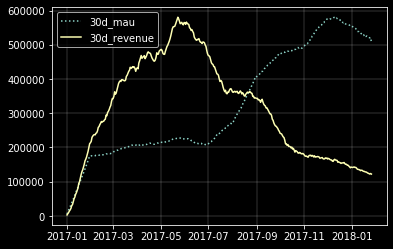

In [174]:
# посмотрим как менялся тренд метрик
coef = rolling_revenue.max() / rolling_mau.max()
fig, ax = plt.subplots()
ax.plot(unique_users_per_day.index, rolling_mau * coef, label="30d_mau", linestyle=":")
ax.plot(rev_per_day.index, rolling_revenue, label="30d_revenue")
ax.grid(True, linewidth=0.2)
ax.legend()
plt.show()

### Общий тренд идет на снижение выручки при постоянном росте MAU

In [231]:
## H0 M1  = M2 
## H1 M1 != M2

In [234]:
import pandas as pd
from scipy.stats import ttest_ind

# Split the dataset into before and after December 15, 2017
before_dec_15 = df[(df['action'] == 'make_order') & (df['date'] < '2017-12-15') & (df['date'] > '2017-01-25')]['sum']
after_dec_15 = df[(df['action'] == 'make_order') & (df['date'] >= '2017-12-15')]['sum']

# Perform t-test for independent samples
t_stat, p_value = ttest_ind(before_dec_15, after_dec_15)
if p_value < 0.05:
    print("Разница значима")
else:
    print("Разница не значима")

Разница значима


In [235]:
before_dec_15.describe()

count    21813.000000
mean       172.834906
std        212.837333
min         10.000000
25%         41.724254
50%         58.637295
75%        250.665725
max       1090.592008
Name: sum, dtype: float64

In [236]:
after_dec_15.describe()

count    3607.000000
mean       50.828240
std        81.978684
min        10.000000
25%        10.000000
50%        33.352843
75%        51.998850
max      1043.995778
Name: sum, dtype: float64

###  Визуально и формально видим разницу между сезонами праздника и без праздника.
Но дело как будто бы не только в празднике, а в тренде на снижение платящей аудитории в общей массе посетителей.

<Figure size 864x576 with 0 Axes>

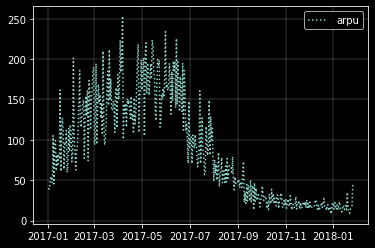

In [329]:
arpu = rev_per_day / unique_users_per_day
fig, ax = plt.subplots()
ax.plot(arpu.index, arpu, label="arpu", linestyle=":")
ax.grid(True, linewidth=0.2)
ax.legend()
plt.show()

### Несмотря на рост пользователей средняя выручка на посетителя сайта неулонно падает. Это означает о каком-либо изменении в:
 - Составе аудитории
 - Поведении аудитории

### Состав аудитории

C:\Users\kamil\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


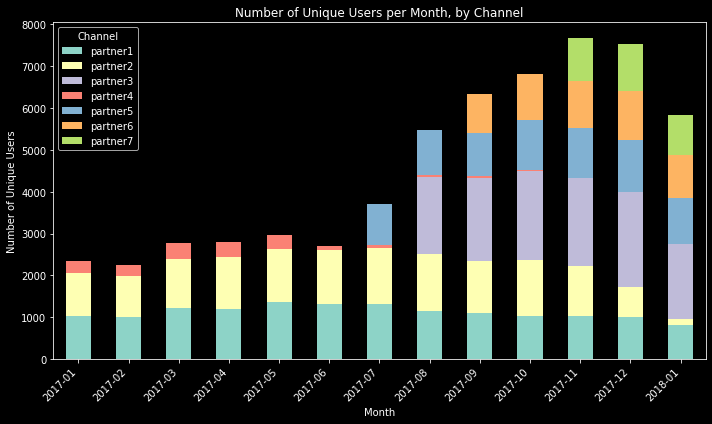

In [362]:
import pandas as pd
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df['date'].dt.to_period('M')
grouped = df.groupby(['month_year', 'channel'])['cid'].nunique().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users per Month, by Channel')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel')
plt.tight_layout()
plt.show()

### Видим, что каждый месяц пропорции между пользователями из разных каналов трафика меняются.

###  Давайте рассматорим распредление платежей пользователей из разных каналов.

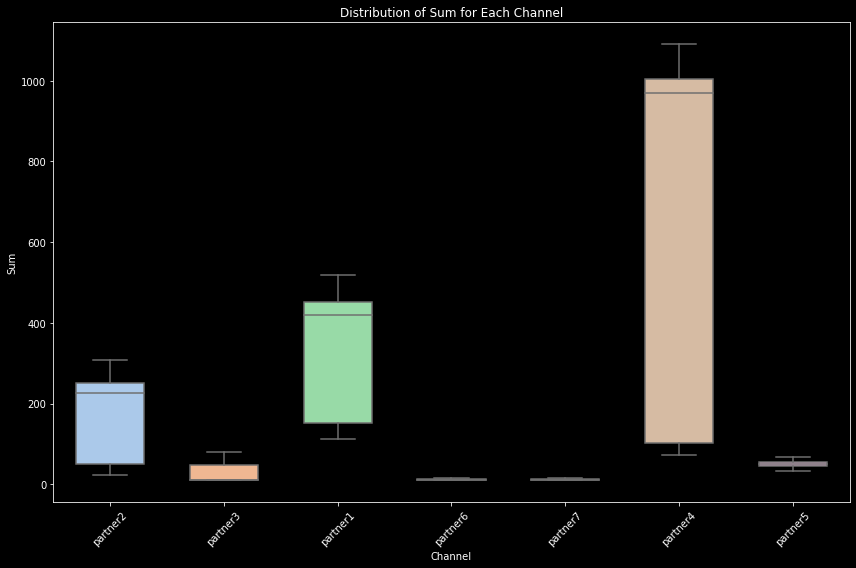

In [328]:
filtered_df = df[df['action'] == 'make_order']
plt.figure(figsize=(12, 8))
sns.boxplot(x='channel', y='sum', data=filtered_df, width=0.6, palette='pastel', showfliers=False)
plt.title('Distribution of Sum for Each Channel')
plt.xlabel('Channel')
plt.ylabel('Sum')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [337]:
filtered_df.groupby('channel')['sum'].median()

channel
partner1    420.399750
partner2    225.941226
partner3     10.000000
partner4    970.507785
partner5     49.972735
partner6     10.199265
partner7     10.081573
Name: sum, dtype: float64

###  Рассматорим долю каждого канала в ежемесячной выручке.

C:\Users\kamil\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


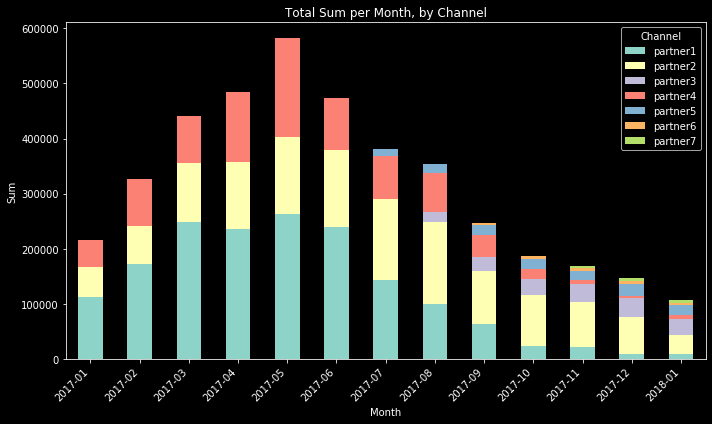

In [336]:
df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df['date'].dt.to_period('M')
grouped = df.groupby(['month_year', 'channel'])['sum'].sum().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Month')
plt.ylabel('Sum')
plt.title('Total Sum per Month, by Channel')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel')
plt.tight_layout()
plt.show()

### Инсайт:
 - у нас растут пропорции неплатящих групп (из каналов 5, 6, 7, 3)
 - у нас падают пропорции платящих групп (из каналов 1, 2, 4)

###  Давайте рассматорим распредление платежей пользователей из разных платформ

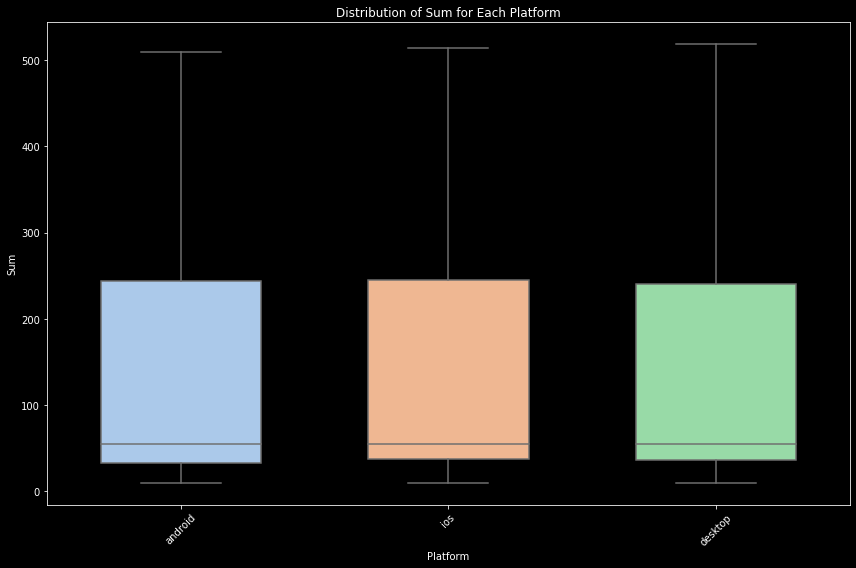

In [334]:
### Расперделение выручки по системам наших пользователей
filtered_df = df[df['action'] == 'make_order']
plt.figure(figsize=(12, 8))
sns.boxplot(x='platform', y='sum', data=filtered_df, width=0.6, palette='pastel', showfliers=False)
plt.title('Distribution of Sum for Each Platform')
plt.xlabel('Platform')
plt.ylabel('Sum')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Инсайт:
 - платформа почти никак не влияет на распределение платежей

### Воронка пользователей по каналам


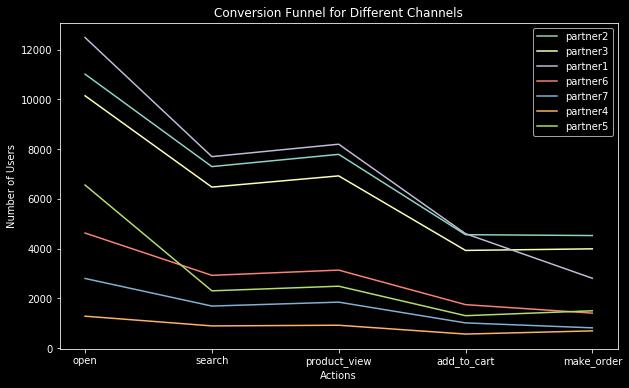

In [347]:
# Define actions in the funnel
funnel_actions = ['open', 'search', 'product_view', 'add_to_cart', 'make_order']

funnel_data = {channel: {action: 0 for action in funnel_actions} for channel in df['channel'].unique()}

for channel in funnel_data.keys():
    channel_df = df[df['channel'] == channel]
    for action in funnel_actions:
        funnel_data[channel][action] = channel_df[channel_df['action'] == action]['cid'].nunique()

plt.figure(figsize=(10, 6))
for channel, data in funnel_data.items():
    plt.plot(funnel_actions, list(data.values()), label=channel)

plt.xlabel('Actions')
plt.ylabel('Number of Users')
plt.title('Conversion Funnel for Different Channels')
plt.legend()
plt.show()

### Интересные детали:
 - группы пользователей из разных каналов похожи своим поведением

### Посмотрим на конверсии из визита в заказ по каналам

In [355]:
df[df['action'] == 'make_order'].groupby(['channel']).count()['platform'] / df[df['action'] == 'open'].groupby(['channel']).count()['platform']

channel
partner1    0.224428
partner2    0.341659
partner3    0.317143
partner4    0.404294
partner5    0.223858
partner6    0.203699
partner7    0.205789
Name: platform, dtype: float64

### Выводы:
- Группы гиганты 1, 2 и 3 похожи, но 3я группа показывает очень высокий процент брошенных корзин за все время, что отражается в участии в выручке
- Группы 4, 5, 6, 7 похожи, но 5я выделяется на общем фоне плохой конверсией в любые действия (проверить на ботов)

### Посмотрим на поведение пользователей на сайте в праздники и до них

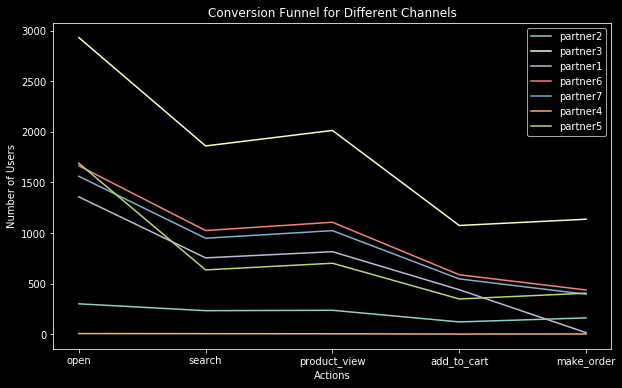

In [357]:
# Define actions in the funnel

holidays = df[df['date'] >= '2017-12-15']
funnel_actions = ['open', 'search', 'product_view', 'add_to_cart', 'make_order']

funnel_data = {channel: {action: 0 for action in funnel_actions} for channel in holidays['channel'].unique()}

for channel in funnel_data.keys():
    channel_df = holidays[holidays['channel'] == channel]
    for action in funnel_actions:
        funnel_data[channel][action] = channel_df[channel_df['action'] == action]['cid'].nunique()

plt.figure(figsize=(10, 6))
for channel, data in funnel_data.items():
    plt.plot(funnel_actions, list(data.values()), label=channel)

plt.xlabel('Actions')
plt.ylabel('Number of Users')
plt.title('Conversion Funnel for Different Channels')
plt.legend()
plt.show()

In [358]:
holidays[holidays['action'] == 'make_order'].groupby(['channel']).count()['platform'] / holidays[holidays['action'] == 'open'].groupby(['channel']).count()['platform']

channel
partner1    0.013685
partner2    0.461912
partner3    0.324579
partner4    0.461538
partner5    0.241214
partner6    0.190987
partner7    0.185924
Name: platform, dtype: float64

In [ ]:
channel
partner1    0.239235 -
partner2    0.337490 +
partner3    0.314601 +
partner4    0.417161 +
partner5    0.218618 +
partner6    0.209661 -
partner7    0.227901 -

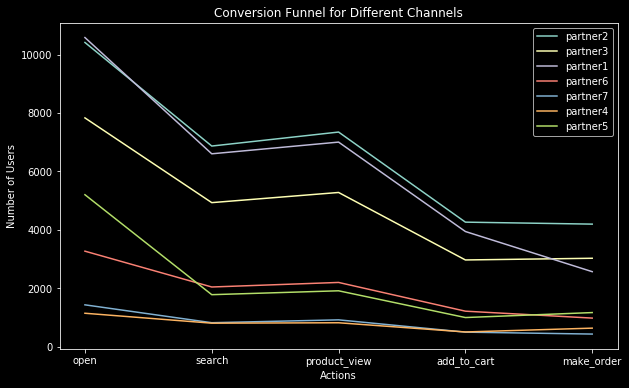

In [359]:
non_holidays = df[(df['date'] < '2017-12-15') & (df['date'] >= '2017-01-25')]
funnel_actions = ['open', 'search', 'product_view', 'add_to_cart', 'make_order']

funnel_data = {channel: {action: 0 for action in funnel_actions} for channel in non_holidays['channel'].unique()}

for channel in funnel_data.keys():
    channel_df = non_holidays[non_holidays['channel'] == channel]
    for action in funnel_actions:
        funnel_data[channel][action] = channel_df[channel_df['action'] == action]['cid'].nunique()

plt.figure(figsize=(10, 6))
for channel, data in funnel_data.items():
    plt.plot(funnel_actions, list(data.values()), label=channel)

plt.xlabel('Actions')
plt.ylabel('Number of Users')
plt.title('Conversion Funnel for Different Channels')
plt.legend()
plt.show()

In [360]:
non_holidays[non_holidays['action'] == 'make_order'].groupby(['channel']).count()['platform'] / non_holidays[non_holidays['action'] == 'open'].groupby(['channel']).count()['platform']

channel
partner1    0.239235
partner2    0.337490
partner3    0.314601
partner4    0.417161
partner5    0.218618
partner6    0.209661
partner7    0.227901
Name: platform, dtype: float64

In [363]:
### Последние две воронки отображают поведение групп до праздничного сезона и в ходе него.

### Выводы по конверсиям:
 - в период праздников почти обнулилась конверсия в покупку у группы Partner 1. Эта группа характеиризуется лучшей платежеспособностью после partner4, а также в течение года имела самое большое количество посещений. Есть аномалия на последнем этапе воронки!
 - в период праздников конверсия в покупку выросла у групп 2,3,4,5. Эти группы можно назвать привлекательными по средним покупкам. У остальных упала.


## Выводы исследования и рекомендации продакту
 - Доля неплатящего трафика растет на протяжении года, а платящие пользователи уходят. На основе отчета выше нужно переприоритезировать каналы трафика по конверсиям и серднему чеку. Выручка на платящих пользователей также падает. Дело тут в том, что группы из разных каналов отличаются значительно и несут разный вклад в совокупную выручку (см. вклад по выручке и вклад по уникальным юзерам)
 - Праздничная конверсия с визита в покупку пользвоателей с канала partner1 упала в 20 раз по сравнению с среднегодовыми значениями. Пользвоатели не примечательны по внешним признакам (схожее распределение платформ и браузеров с другимим). Оставляют брошенные корзины. Надо проверить на ботов.
 - Partner4 - самый желанный тип трафика, показывающий конверсию 40+% при максимальном среднем чеке. Возможно это B2B направление. Является самой малочисленной группой.
 - Каналы 1,2,4 давали уверенный рост выручки сначала года. В ходе уменьшения количества пользователей из этих каналов выручка начала явно слабеть.
 - Сезонность обосновать нельзя по причине общего тренда на спад. Упадок конверсии в большой группе мог привести к дпоолнительным потерям выручки, однако общий неплатящий поток пользователей сделал свое дело.